
Finetuning Torchvision Models
=============================

torchvision [models](https://pytorch.org/vision/stable/models.html) and [datasets](https://pytorch.org/vision/stable/datasets.html)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import numpy as np
import time

# Helper Functions
from libs.torchvision.torchvision_models import initialize_model
from libs.torchvision.torchvision_train import train_model
from libs import splitfolders
from libs.common import load_dict, dump_dict, date2string, ensure_tuple, tensor_to_array
from libs.albumentations_utils import get_transforms

from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

%matplotlib inline

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.8.0+cu128
Torchvision Version:  0.23.0+cu128


## Settings

In [2]:
settings = load_dict('settings_torchvision.yaml')

# Load all experiment settings from settings
raw_data_dir = settings.get('raw_data_dir', None)
split_data_dir = settings.get('split_data_dir', None)
split_ratio = settings.get('split_ratio', None)
copy_dataset = settings.get('copy_dataset', None)
dloader_workers = settings.get('dloader_workers', 0)

model_type = settings['model_type']
batch_size = settings['batch_size']
num_epochs = settings['num_epochs']
learning_rate = float(settings['learning_rate'])
optimizer_name = settings['optimizer_name']
train_deep = settings['train_deep']
add_softmax = settings['add_softmax']

# Ensure scale_range and input_size are valid tuples for albumentations
scale_range = ensure_tuple(settings['scale_range'], length=2, dtype=float)
input_size = ensure_tuple(settings['input_size'], length=2, dtype=int)

output_dir = settings['output_dir']
scheduler_type = settings['scheduler']
scheduler_patience = settings['scheduler_patience']
scheduler_factor = settings['scheduler_factor']
early_stopping_patience = settings['early_stopping_patience']
use_augmentations = settings['augmentations']
mean = np.array(IMAGENET_DEFAULT_MEAN)
std = np.array(IMAGENET_DEFAULT_STD)
model_list = settings['model_list']

os.makedirs(output_dir, exist_ok=True)

model_name = model_type
output_path = os.path.join(output_dir, model_name + ".pth")
json_path = os.path.join(output_dir, model_name + "_metadata.json")

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# check if model_type exists
if not model_type in model_list:
    print(f"ERROR: model {model_type} unknown!")

# Flexible optimizer selection
def get_optimizer(optimizer_name, params, lr):
    if optimizer_name.lower() == 'adam':
        return optim.Adam(params, lr=lr)
    elif optimizer_name.lower() == 'adamw':
        return optim.AdamW(params, lr=lr)
    elif optimizer_name.lower() == 'sgd':
        return optim.SGD(params, lr=lr, momentum=0.9)
    elif optimizer_name.lower() == 'rmsprop':
        return optim.RMSprop(params, lr=lr)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

### Split dataset

In [3]:
# Ensure split_data_dir and raw_data_dir are set, fallback to defaults if missing
split_data_dir = settings.get('split_data_dir')
raw_data_dir = settings.get('raw_data_dir')

split_ratio = settings['split_ratio']
copy_dataset = settings['copy_dataset']

# check if dataset is already splitted
if not splitfolders.check_existence(split_data_dir, dirs=["val", "test", "train"]):

    # copy or move dataset split into train, validation and test
    splitfolders.ratio(raw_data_dir, output=split_data_dir, 
                       seed=1337, ratio=split_ratio,
                       group_prefix=None, 
                       move=not(copy_dataset))

In [4]:
# Number of classes in the dataset

def count_directories(path):
    return len([name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))])

num_classes = count_directories(os.path.join(split_data_dir, "train"))
print(f"Number of classes: {num_classes}")

Number of classes: 5


----------------
# Training

## initialize model

In [5]:
# Initialize the model for this run
model, input_size = initialize_model(model_type, num_classes, train_deep, add_softmax=add_softmax)

### Load Data
----------------
Now that we know what the input size must be, we can initialize the data
transforms, image datasets, and the dataloaders. Notice, the models were
pretrained with the hard-coded normalization values, as described
`here <https://pytorch.org/docs/master/torchvision/models.html>`__.




In [6]:
# Data augmentation and normalization for training: http://pytorch.org/vision/main/transforms.html
# Use mean and std from settings, and enable albumentations if requested

data_transforms = get_transforms(input_size, scale_range=scale_range, hflip=0.5, mean=mean, std=std)

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(split_data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=dloader_workers) for x in ['train', 'val']}

class_labels = image_datasets['train'].classes
print("class_labels:", class_labels)

class_labels: ['ants', 'bees', 'cats', 'dogs', 'none']


In [7]:
def visualize_model(model, device=device, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders_dict['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            top_probs, top_labels = torch.max(probabilities, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')

                class_label = class_labels[top_labels[j]]
                probability = top_probs[j].cpu().numpy()
                ax.set_title(f'predicted: {class_label} ({probability:.2f})')

                # Fix: Call the function with proper arguments
                img = tensor_to_array(inputs, idx=j, mean=mean, std=std)
                plt.imshow(img)
            
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
        model.train(mode=was_training)

## Create the Optimizer
--------------------

Now that the model structure is correct, the final step for finetuning
and feature extracting is to create an optimizer that only updates the
desired parameters. Recall that after loading the pretrained model, but
before reshaping, if ``train_deep=False`` we manually set all of the
parameter’s ``.requires_grad`` attributes to False. Then the
reinitialized layer’s parameters have ``.requires_grad=True`` by
default. So now we know that *all parameters that have
.requires_grad=True should be optimized.* Next, we make a list of such
parameters and input this list to the SGD algorithm constructor.

To verify this, check out the printed parameters to learn. When
finetuning, this list should be long and include all of the model
parameters. However, when feature extracting this list should be short
and only include the weights and biases of the reshaped layers.

--------------------
[using Adam instead of SGD](https://analyticsindiamag.com/ultimate-guide-to-pytorch-optimizers/)


In [8]:
# Send the model to GPU if possible
model = model.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
#print("Params to learn:")
if not train_deep:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            #print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            #print("\t",name)
            continue

# Observe that all parameters are being optimized
optimizer_ft = get_optimizer(optimizer_name, params_to_update, learning_rate)

## Run Training and Validation Step
--------------------------------

Finally, the last step is to setup the loss for the model, then run the
training and validation function for the set number of epochs. Notice,
depending on the number of epochs this step may take a while on a CPU.
Also, the default learning rate is not optimal for all of the models, so
to achieve maximum accuracy it would be necessary to tune for each model
separately.




In [ ]:
# Setup the loss function
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler (ReduceLROnPlateau on val loss)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', factor=0.5, patience=3)

# Early stopping and checkpointing settings
early_stopping_patience = 7  # stop if no val loss improvement for 7 epochs
checkpoint_best_path = os.path.join(output_dir, model_name + '_best.pth')
os.makedirs(output_dir, exist_ok=True)

starttime = time.time()

# Train and evaluate with all modern features
model, val_acc_history, val_loss_history = train_model(
    model, dataloaders_dict, criterion, optimizer_ft,
    num_epochs=num_epochs, device=device,
    scheduler=scheduler,
    early_stopping_patience=early_stopping_patience,
    checkpoint_path=checkpoint_best_path
)

training_duration = time.time() - starttime

best_val_acc = round(float(max(val_acc_history)), 4)
last_val_acc = round(float(val_acc_history[-1]), 4)

print("best_val_acc:", best_val_acc)
print("last_val_acc:", last_val_acc)

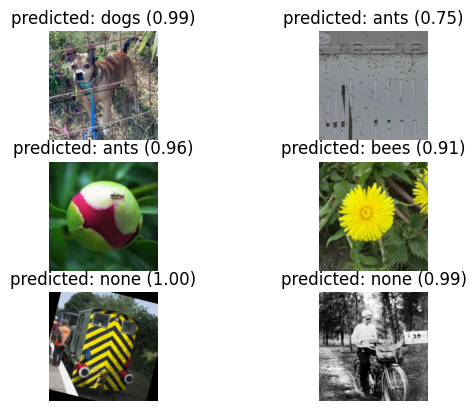

In [10]:
visualize_model(model, device=device)

## Save Checkpoint
[saving and loading checkpoints tutorial](https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html) , [stackoverflow](https://stackoverflow.com/questions/42703500/how-do-i-save-a-trained-model-in-pytorch)



In [11]:
# torch.save({
#             'epoch': num_epochs,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer_ft.state_dict(),
#             'loss': LOSS,
#             }, output_path)

torch.save(model, output_path)


# Write variables to a JSON file
data = {
    'date_created':             date2string(),
    'model_type':               model_type, 
    'input_size':               input_size,
    'has_softmax':              add_softmax,
    'class_labels':             class_labels, 
    'initial_learning_rate':    learning_rate,
    'epochs':                   num_epochs,
    'training_time':            training_duration,
    'best_val_acc':             best_val_acc,
    'last_val_acc':             last_val_acc
    }

dump_dict(data, json_path, update=False)

### convert to ONNX

In [ ]:
model.eval()

# # Define the data transformations (same as used during training)
# data_transforms = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# Load a sample image from your validation dataset
images_dir = os.path.join(split_data_dir, "val")
image_datasets = datasets.ImageFolder(images_dir, data_transforms["val"])
dataloader = torch.utils.data.DataLoader(image_datasets, batch_size=1, shuffle=True)

# Get a single batch (one image)
inputs, _ = next(iter(dataloader))

# Move the model and inputs to the same device (CPU or GPU)
model.to(device)
inputs = inputs.to(device)


onnx_path = os.path.join(output_dir, model_name + ".onnx")

# Export the model
torch.onnx.export(
    model, inputs, onnx_path,
    input_names=['input'], output_names=['output'],
    dynamic_shapes=[{0: 'batch'}],
    dynamo=True,
    external_data=False  # don't save data as a second file
)


----------------
# Test

### Load Checkpoint and Data Loader

[tutorial](https://towardsdatascience.com/how-to-save-and-load-a-model-in-pytorch-with-a-complete-example-c2920e617dee)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64

# # Remember to first initialize the model and optimizer, then load the dictionary locally.
# model, input_size = initialize_model(model_type, num_classes, train_deep)
# model = model.to(device)

# optimizer = optim.Adam(model.parameters(), lr=0.001)

# checkpoint = torch.load(output_path)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']


# Allowlist EfficientNet for unpickling if you trust the source
import torch.serialization
torch.serialization.add_safe_globals([torchvision.models.efficientnet.EfficientNet])

model = torch.load(output_path, weights_only=False)
model = model.to(device)
model.eval()  # set dropout and batch normalization layers to evaluation mode before running inference


# create data loader for test-data
test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

In [14]:
test_dir = os.path.join(split_data_dir, "test")

testset = datasets.ImageFolder(test_dir, test_transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

test_acc = 0.0
for samples, labels in test_loader:
    with torch.no_grad():
        samples, labels = samples.to(device), labels.to(device)
        output = model(samples)

        # calculate accuracy
        pred = torch.argmax(output, dim=1)
        correct = pred.eq(labels)
        test_acc += torch.mean(correct.float())

testimage_count = len(testset)
test_result = test_acc.item()/len(test_loader)
print(f'Accuracy of the network on {testimage_count} test images: {round(test_result * 100.0, 2)}%')


Accuracy of the network on 105 test images: 95.22%


In [15]:
# update metadata with test accuracy
data = {'date_modified': date2string(), 'test_acc': round(test_result, 2)}
dump_dict(data, json_path, update=True)

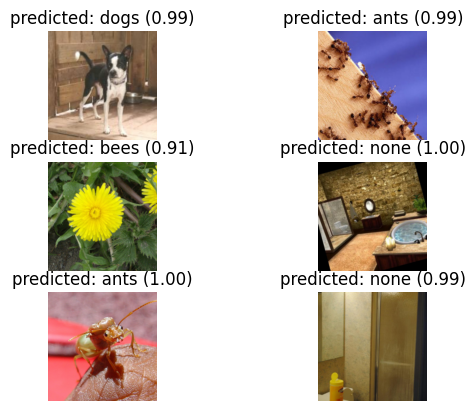

In [16]:
visualize_model(model, device=device, num_images=6)